# Validation of effective Hamiltonian extraction

In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.30'
os.environ['CUDA_VISIBLE_DEVICES'] = '2,3'
#os.environ['JAX_LOG_COMPILES'] = 'True'
import logging
import numpy as np
import matplotlib.pyplot as plt
import h5py
import rqutils.paulis as paulis
from rqutils.qprint import qprint
from rqutils.math import matrix_exp, matrix_angle
import qudit_sim
import optax

qudit_sim.config.jax_devices = [0, 1]
qudit_sim.config.pulse_sim_solver = 'jax'

try:
    os.makedirs('heff_validation')
except OSError:
    pass

## Single qubit resonant drive

In [2]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')

In [3]:
hgen.add_drive('q0', frequency=100., amplitude=0.1)
hgen.use_rwa = True
qudit_sim.visualization.print_hamiltonian(hgen.build())

<IPython.core.display.Latex object>

In [4]:
hgen.use_rwa = False
components = qudit_sim.apps.find_heff(hgen, 'q0', frequency=100., amplitude=0.1, cycles=100., save_result_to='heff_validation/single_qubit_resonant', log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 2401 time points from 0.000e+00 to 1.885e+01
INFO:qudit_sim.pulse_sim:XLA-compiled Hamiltonian built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 3.080622 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/single_qubit_resonant.h5
INFO:qudit_sim.apps.find_heff:Determining the initial values for Heff and offset..
INFO:qudit_sim.apps.find_heff:Maximizing mean fidelity..
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 5 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets with minimum fidelity 0.999993


In [5]:
qudit_sim.visualization.print_components(components)

<IPython.core.display.Latex object>

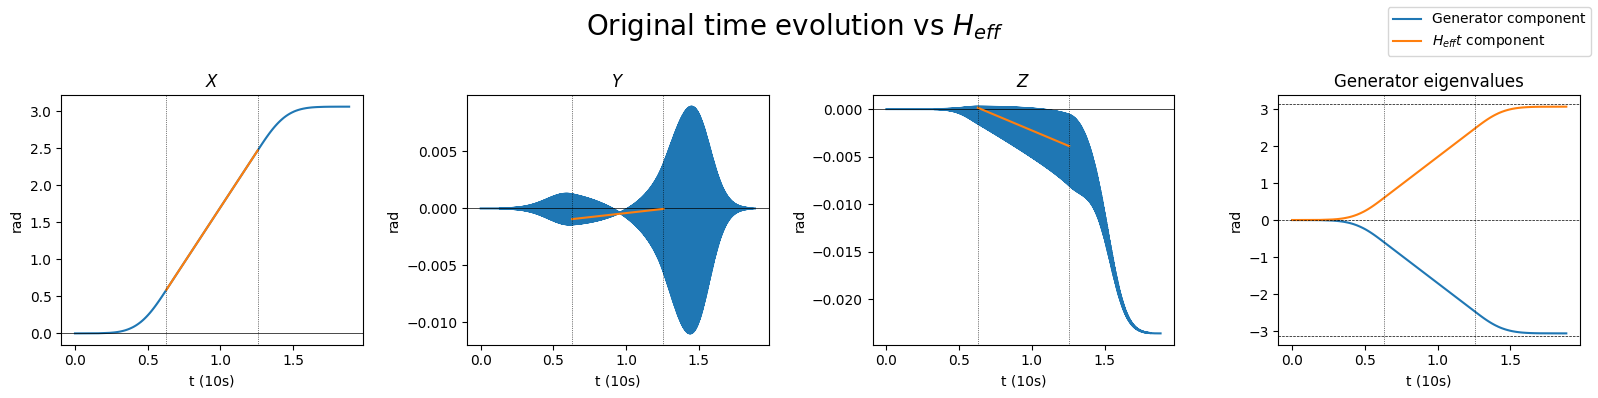

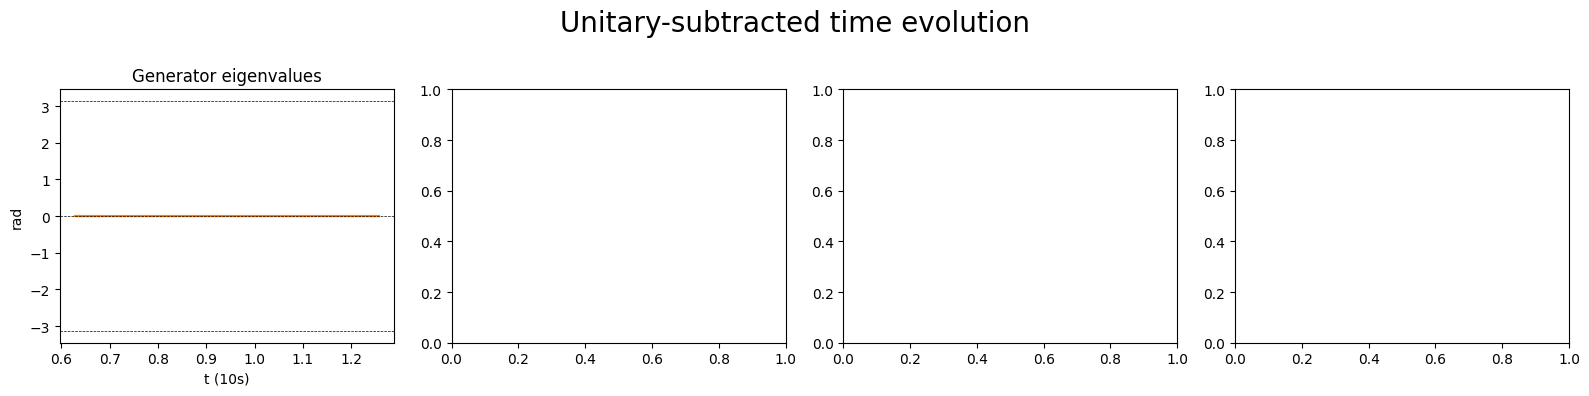

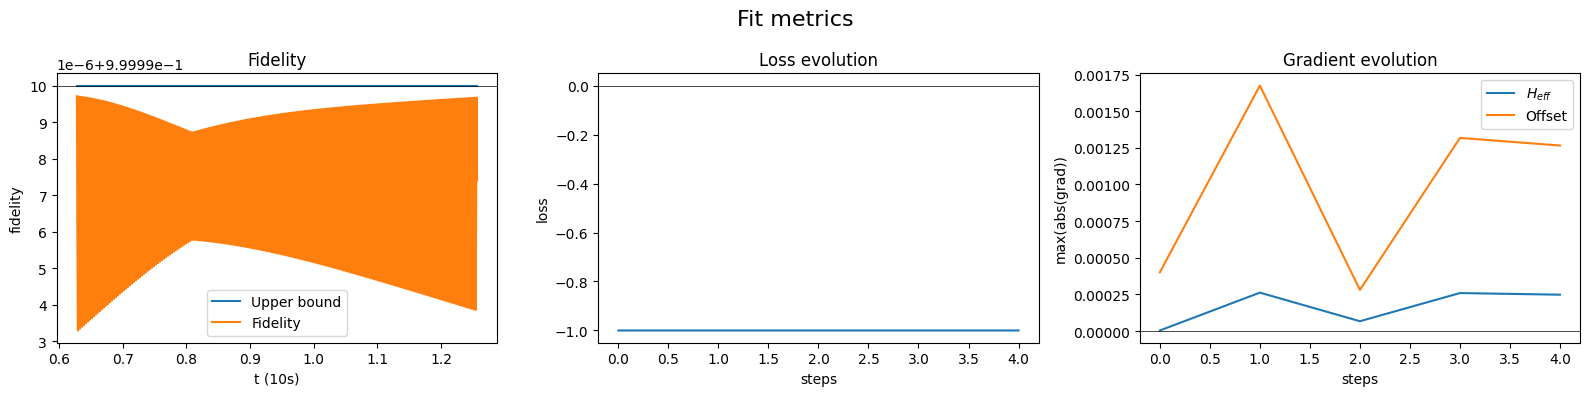

In [6]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/single_qubit_resonant.h5', align_ylim=False);

## Single qubit off-resonant drive

When the drive is slightly off-resonant, it becomes hard to define an effective Hamiltonian, but there is some linear dependency that can be extracted.

In [7]:
hgen = qudit_sim.HamiltonianBuilder(2)
qubit_freq = 100.
drive_freq = 100.1
drive_amp = 0.1
hgen.add_qudit(qubit_frequency=qubit_freq, anharmonicity=-8., drive_amplitude=6., qudit_id='q0')
components = qudit_sim.apps.find_heff(hgen,
                                      qudit='q0',
                                      frequency=drive_freq,
                                      amplitude=drive_amp,
                                      min_fidelity=0.,
                                      save_result_to='heff_validation/single_qubit_offresonant',
                                      log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 9601 time points from 0.000e+00 to 7.532e+01
INFO:qudit_sim.pulse_sim:XLA-compiled Hamiltonian built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 1.129515 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/single_qubit_offresonant.h5
INFO:qudit_sim.apps.find_heff:Determining the initial values for Heff and offset..
INFO:qudit_sim.apps.find_heff:Maximizing mean fidelity..
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 904 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets with minimum fidelity 0.000000


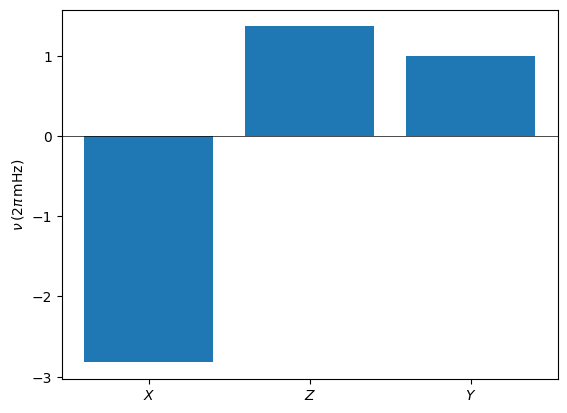

In [8]:
qudit_sim.visualization.plot_components(components, threshold=0.001);

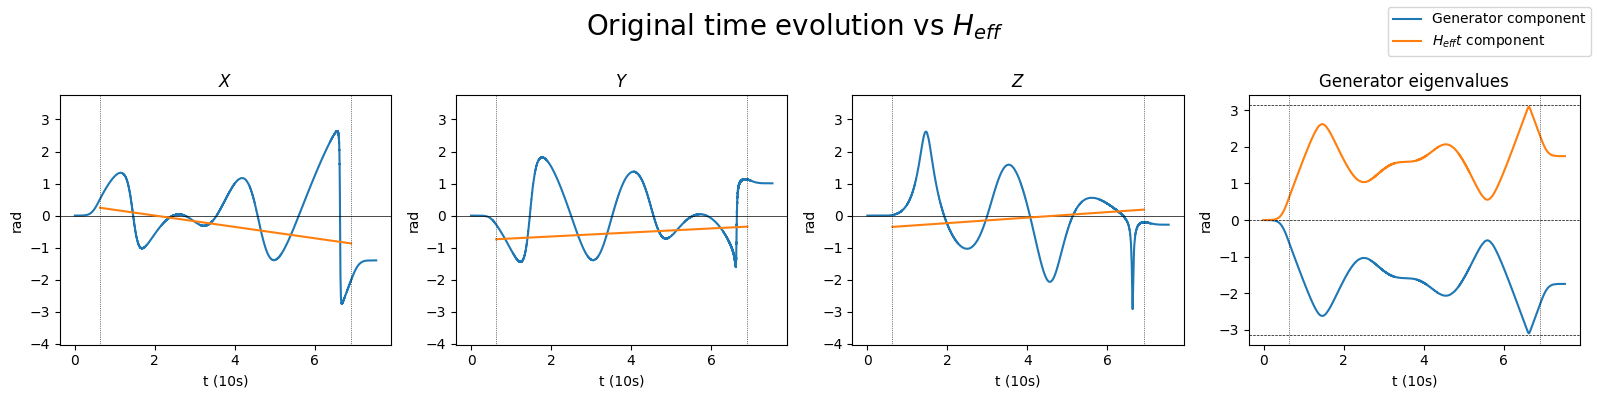

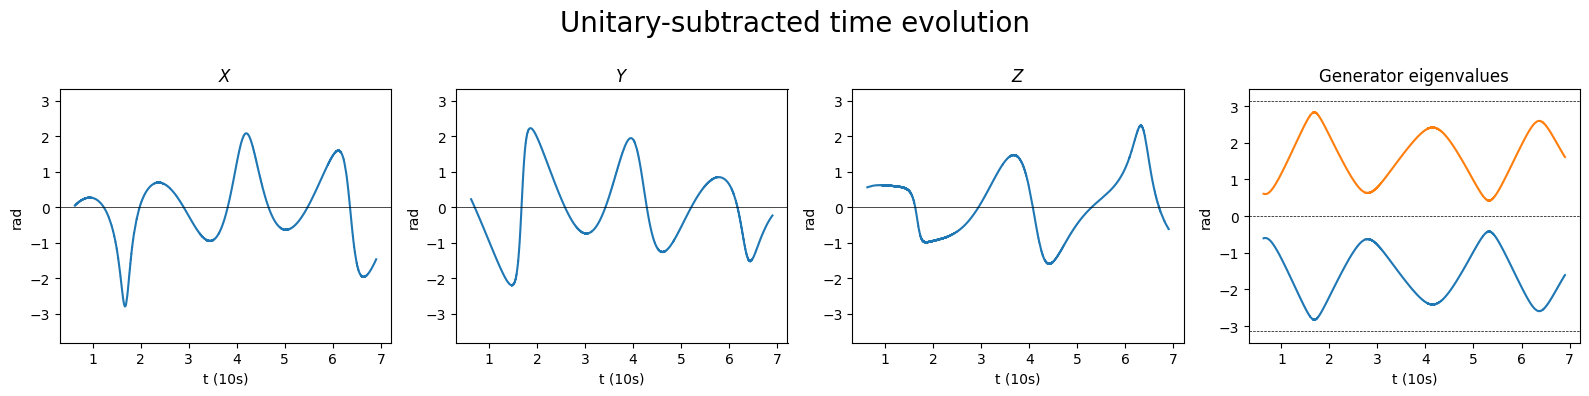

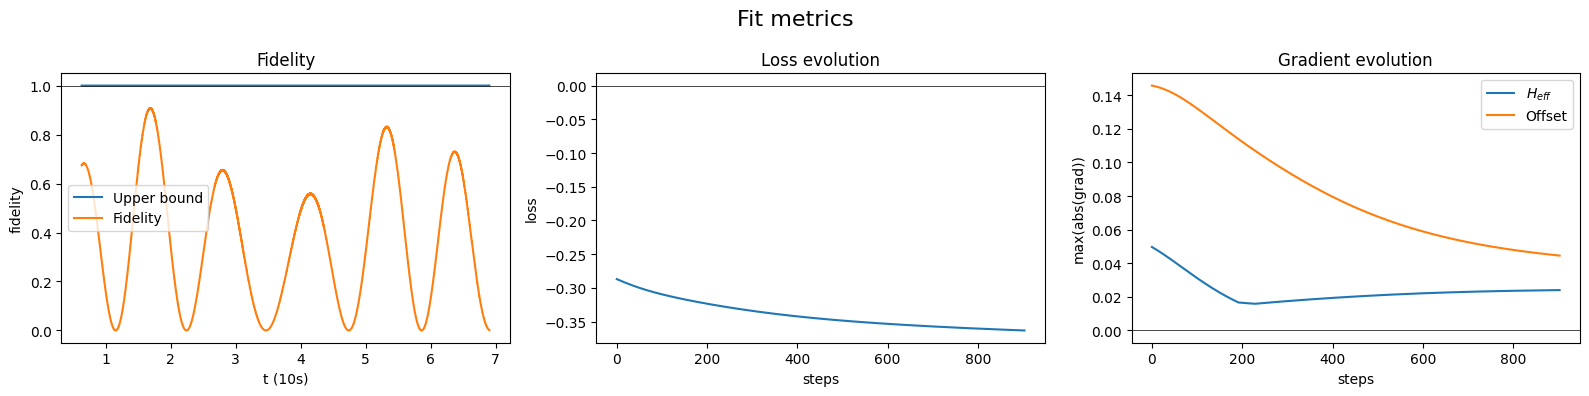

In [9]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/single_qubit_offresonant.h5');

## Single qutrit qubit-resonant drive, qubit $H_{\mathrm{eff}}$ extraction

In [10]:
hgen = qudit_sim.HamiltonianBuilder(3)
hgen.add_qudit(qubit_frequency=100., anharmonicity=-8., drive_amplitude=6., qudit_id='q0')

In [11]:
hgen.add_drive('q0', frequency=100., amplitude=0.1)
hgen.use_rwa = True
qudit_sim.visualization.print_hamiltonian(hgen.build())

<IPython.core.display.Latex object>

In [12]:
hgen.use_rwa = False
components = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=100., amplitude=0.1, comp_dim=2, save_result_to='heff_validation/single_qutrit_resonant', log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 9601 time points from 0.000e+00 to 7.540e+01
INFO:qudit_sim.pulse_sim:XLA-compiled Hamiltonian built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 1.256515 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/single_qutrit_resonant.h5
INFO:qudit_sim.apps.find_heff:Determining the initial values for Heff and offset..
INFO:qudit_sim.apps.find_heff:Maximizing mean fidelity..
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 5 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets with minimum fidelity 0.998303


In [13]:
qudit_sim.visualization.print_components(components, threshold=0.)

<IPython.core.display.Latex object>

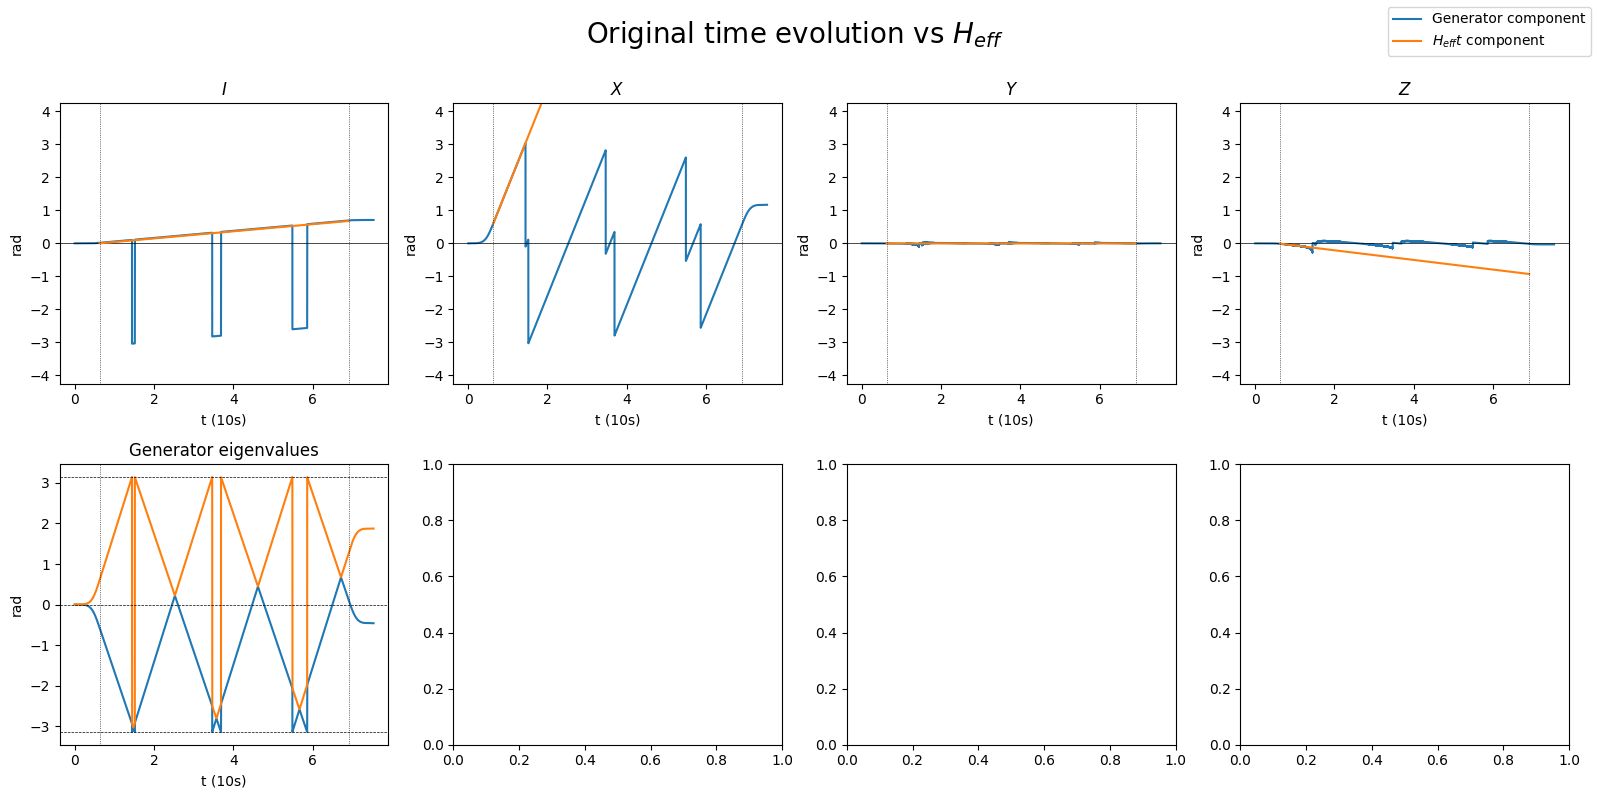

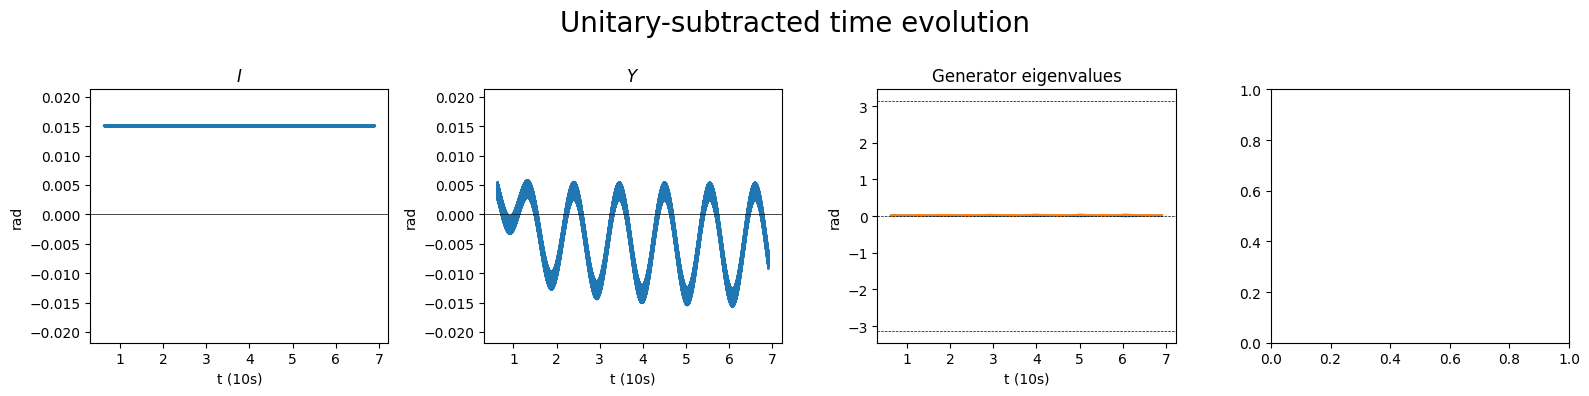

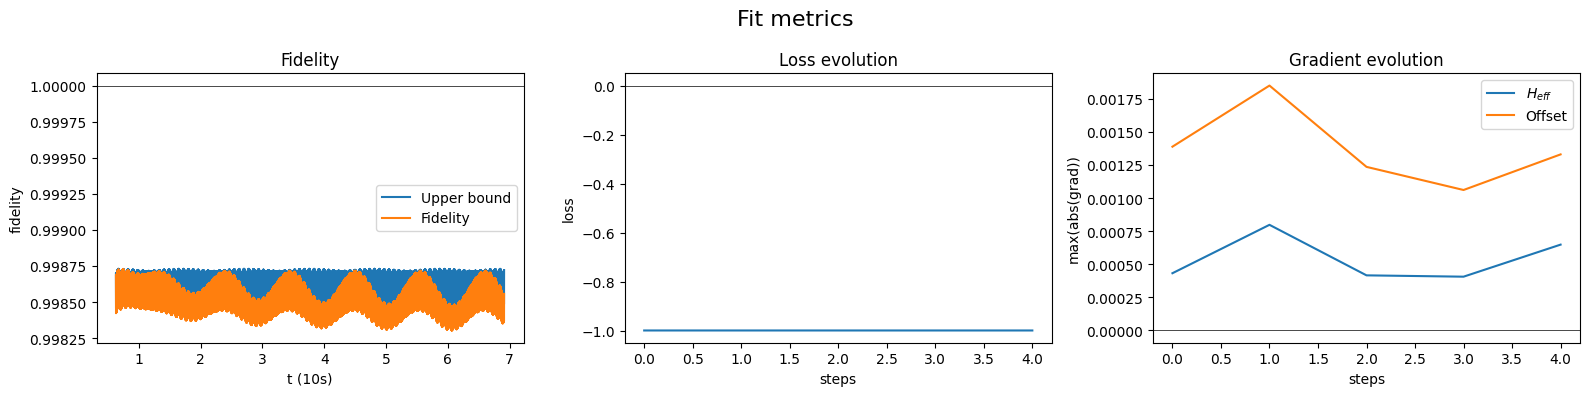

In [14]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/single_qutrit_resonant.h5');

## Two qubit cross resonance, no crosstalk

In [15]:
hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 30.)
drive_frequency = hgen.dressed_frequencies('q1')[0]

In [16]:
hgen.add_drive('q0', frequency=drive_frequency, amplitude=0.2)
hgen.use_rwa = True
qudit_sim.visualization.print_hamiltonian(hgen.build())

<IPython.core.display.Latex object>

In [17]:
hgen.use_rwa = False
components = qudit_sim.apps.find_heff(hgen, qudit='q0', frequency=drive_frequency, amplitude=0.2, save_result_to='heff_validation/cross_resonance', log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 9601 time points from 0.000e+00 to 6.854e-02
INFO:qudit_sim.pulse_sim:XLA-compiled Hamiltonian built. Starting simulation..
INFO:qudit_sim.pulse_sim:Done in 1.291306 seconds.
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/cross_resonance.h5
INFO:qudit_sim.apps.find_heff:Determining the initial values for Heff and offset..
INFO:qudit_sim.apps.find_heff:Maximizing mean fidelity..
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 5 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets with minimum fidelity 0.996039


In [18]:
qudit_sim.visualization.print_components(components)

<IPython.core.display.Latex object>

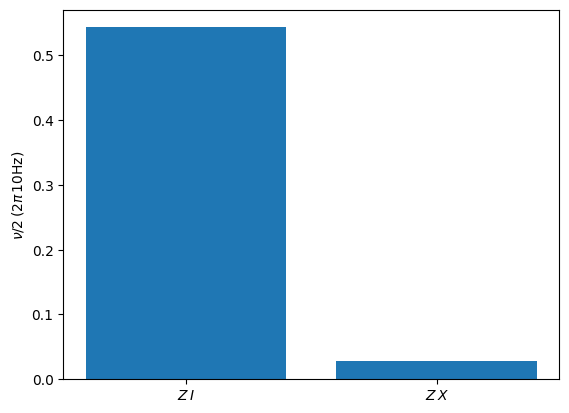

In [19]:
qudit_sim.visualization.plot_components(components);

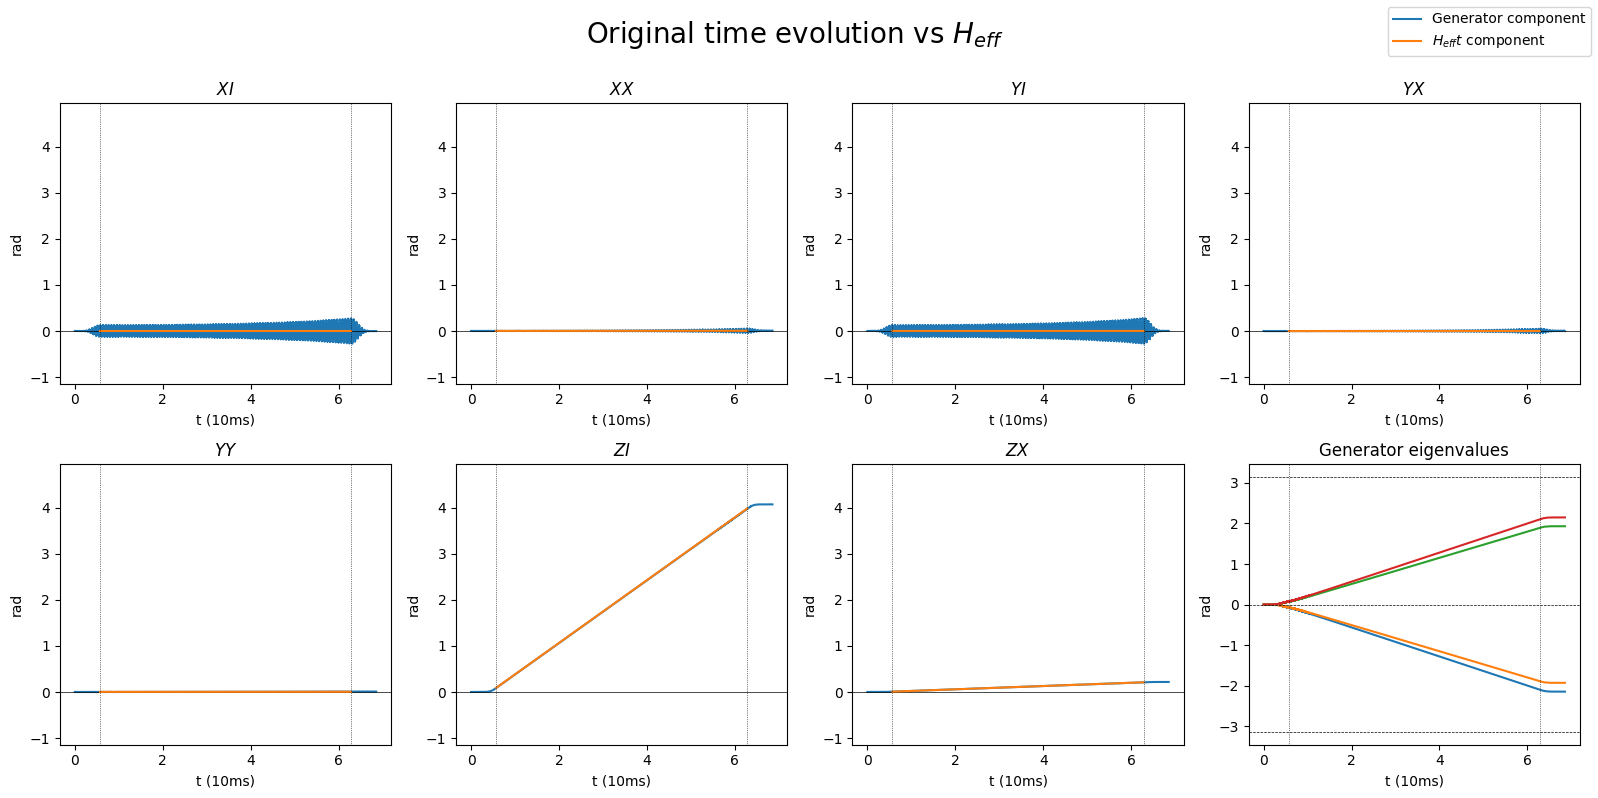

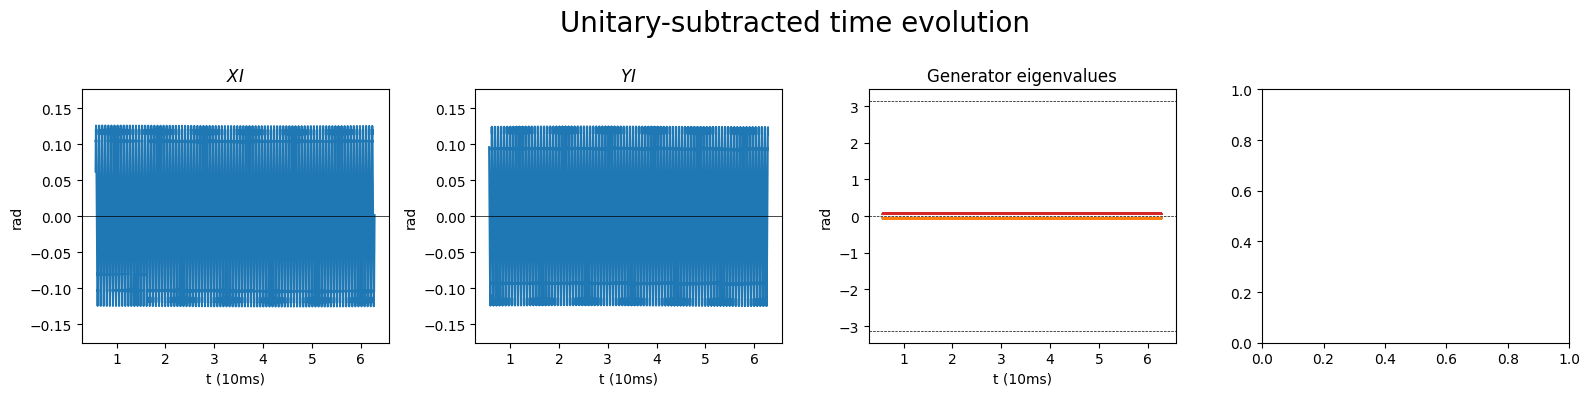

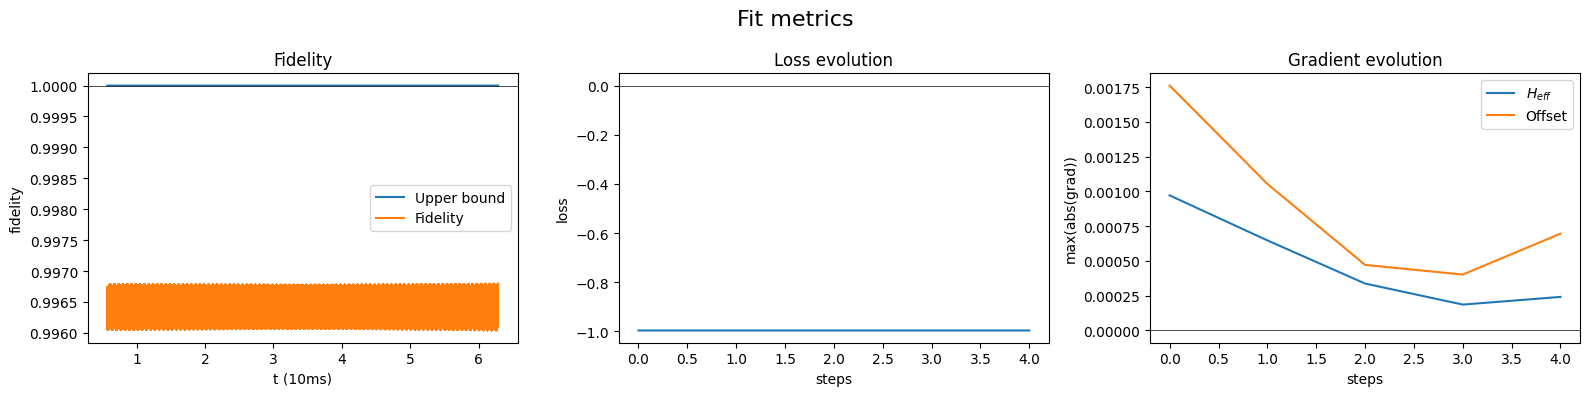

In [20]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/cross_resonance.h5');

## Cross resonance amplitude scan

In [21]:
import time

amplitudes = np.linspace(0., 0.25, 10)

hgen = qudit_sim.HamiltonianBuilder(2)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 30.)
drive_frequency = hgen.dressed_frequencies('q1')[0]

start = time.time()
components_list = qudit_sim.apps.find_heff(hgen,
                                           qudit='q0',
                                           frequency=drive_frequency,
                                           amplitude=amplitudes,
                                           save_result_to='heff_validation/cr_amplitude_scan',
                                           log_level=logging.INFO)
print('threads:', time.time() - start)

INFO:qudit_sim.parallel:Executing _run_single in 10 parallel (max 64 simultaneous) threads..
INFO:qudit_sim.pulse_sim.0:Using 9601 time points from 0.000e+00 to 6.854e-02
INFO:qudit_sim.pulse_sim.0:XLA-compiled Hamiltonian built. Starting simulation..
INFO:qudit_sim.pulse_sim.1:Using 9601 time points from 0.000e+00 to 6.854e-02
INFO:qudit_sim.pulse_sim.1:XLA-compiled Hamiltonian built. Starting simulation..
INFO:qudit_sim.pulse_sim.2:Using 9601 time points from 0.000e+00 to 6.854e-02
INFO:qudit_sim.pulse_sim.2:XLA-compiled Hamiltonian built. Starting simulation..
INFO:qudit_sim.pulse_sim.3:Using 9601 time points from 0.000e+00 to 6.854e-02
INFO:qudit_sim.pulse_sim.4:Using 9601 time points from 0.000e+00 to 6.854e-02
INFO:qudit_sim.pulse_sim.3:XLA-compiled Hamiltonian built. Starting simulation..
INFO:qudit_sim.pulse_sim.5:Using 9601 time points from 0.000e+00 to 6.854e-02
INFO:qudit_sim.pulse_sim.4:XLA-compiled Hamiltonian built. Starting simulation..
INFO:qudit_sim.pulse_sim.6:Using 9

threads: 19.457364797592163


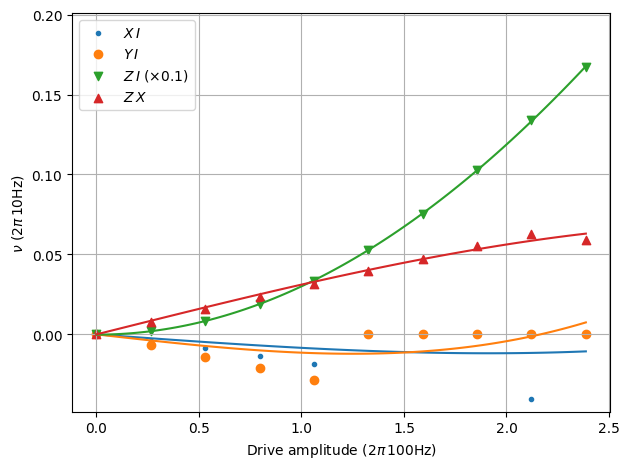

In [22]:
physical_amplitudes = amplitudes * hgen.qudit_params('q0').drive_amplitude
fig, coefficients, indices, amp_scale, compo_scale = qudit_sim.visualization.plot_amplitude_scan(physical_amplitudes, components_list)

In [23]:
qudit_sim.visualization.print_amplitude_scan(coefficients, indices, amp_scale, compo_scale)

<IPython.core.display.Latex object>

## Two qutrit no drive

Statically coupled qudits feature "always-on" diagonal effective Hamiltonian because of the dressing of energy levels.
Here we use a two-qutrit system with an unrealistically large coupling to illustrate this point.

In [24]:
hgen = qudit_sim.HamiltonianBuilder(3)
hgen.add_qudit(qubit_frequency=100000., anharmonicity=-8000., drive_amplitude=6000., qudit_id='q0')
hgen.add_qudit(qubit_frequency=110000., anharmonicity=-7000., drive_amplitude=7000., qudit_id='q1')
hgen.add_coupling('q0', 'q1', 3000.)

In [25]:
# Pass a null tuple to qudit, frequency, and amplitude to run a no-drive Heff analysis
components = qudit_sim.apps.find_heff(hgen,
                                      qudit=tuple(),
                                      frequency=tuple(),
                                      amplitude=tuple(),
                                      comp_dim=2,
                                      cycles=50,
                                      min_fidelity=0.5,
                                      save_result_to='heff_validation/two_qutrit_hstat',
                                      log_level=logging.INFO)

INFO:qudit_sim.pulse_sim:Using 401 time points from 0.000e+00 to 2.835e-03
INFO:qudit_sim.pulse_sim:Static Hamiltonian built. Exponentiating..
INFO:qudit_sim.pulse_sim:Saving the simulation result to heff_validation/two_qutrit_hstat.h5
INFO:qudit_sim.apps.find_heff:Determining the initial values for Heff and offset..
INFO:qudit_sim.apps.find_heff:Maximizing mean fidelity..
INFO:qudit_sim.apps.find_heff:Starting maximization loop..
INFO:qudit_sim.apps.find_heff:Done after 218 steps.
INFO:qudit_sim.apps.find_heff:Found Heff and offsets with minimum fidelity 0.603243


In [26]:
qudit_sim.visualization.print_components(components)

<IPython.core.display.Latex object>

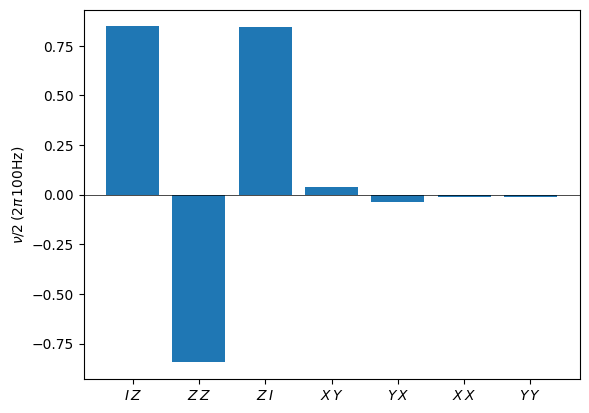

In [27]:
qudit_sim.visualization.plot_components(components);

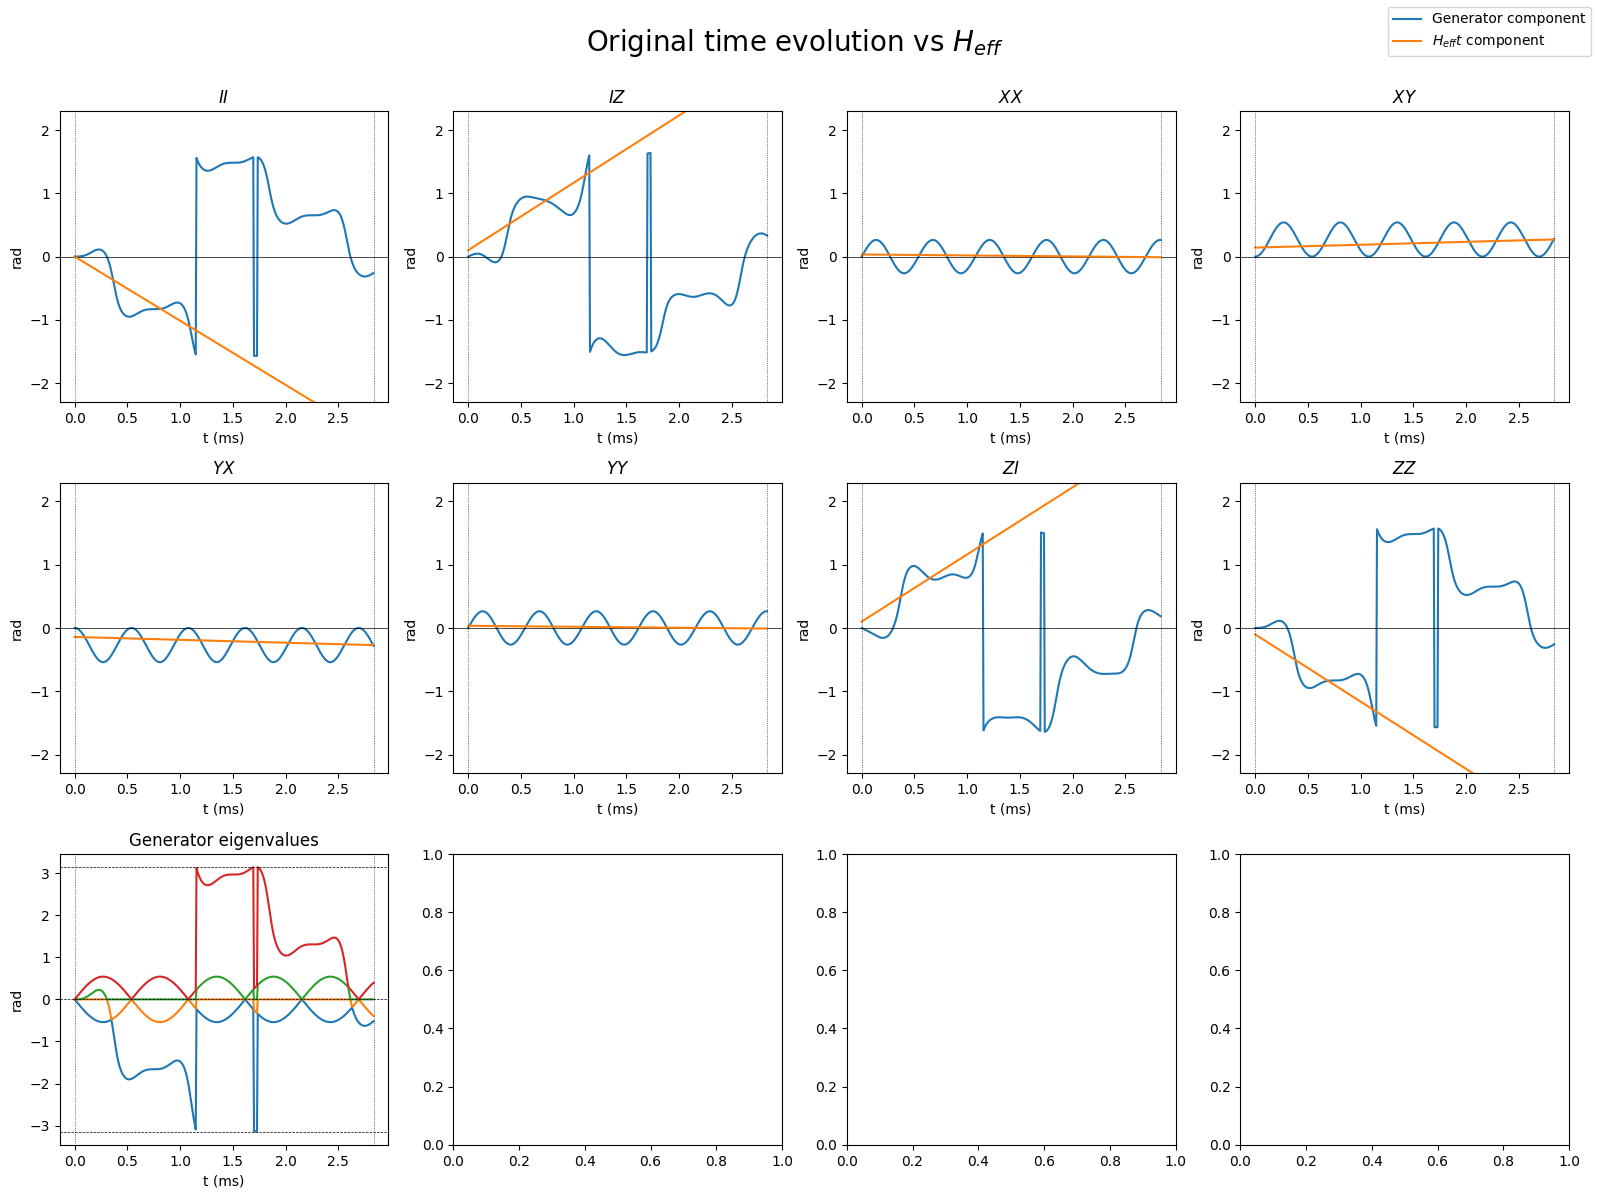

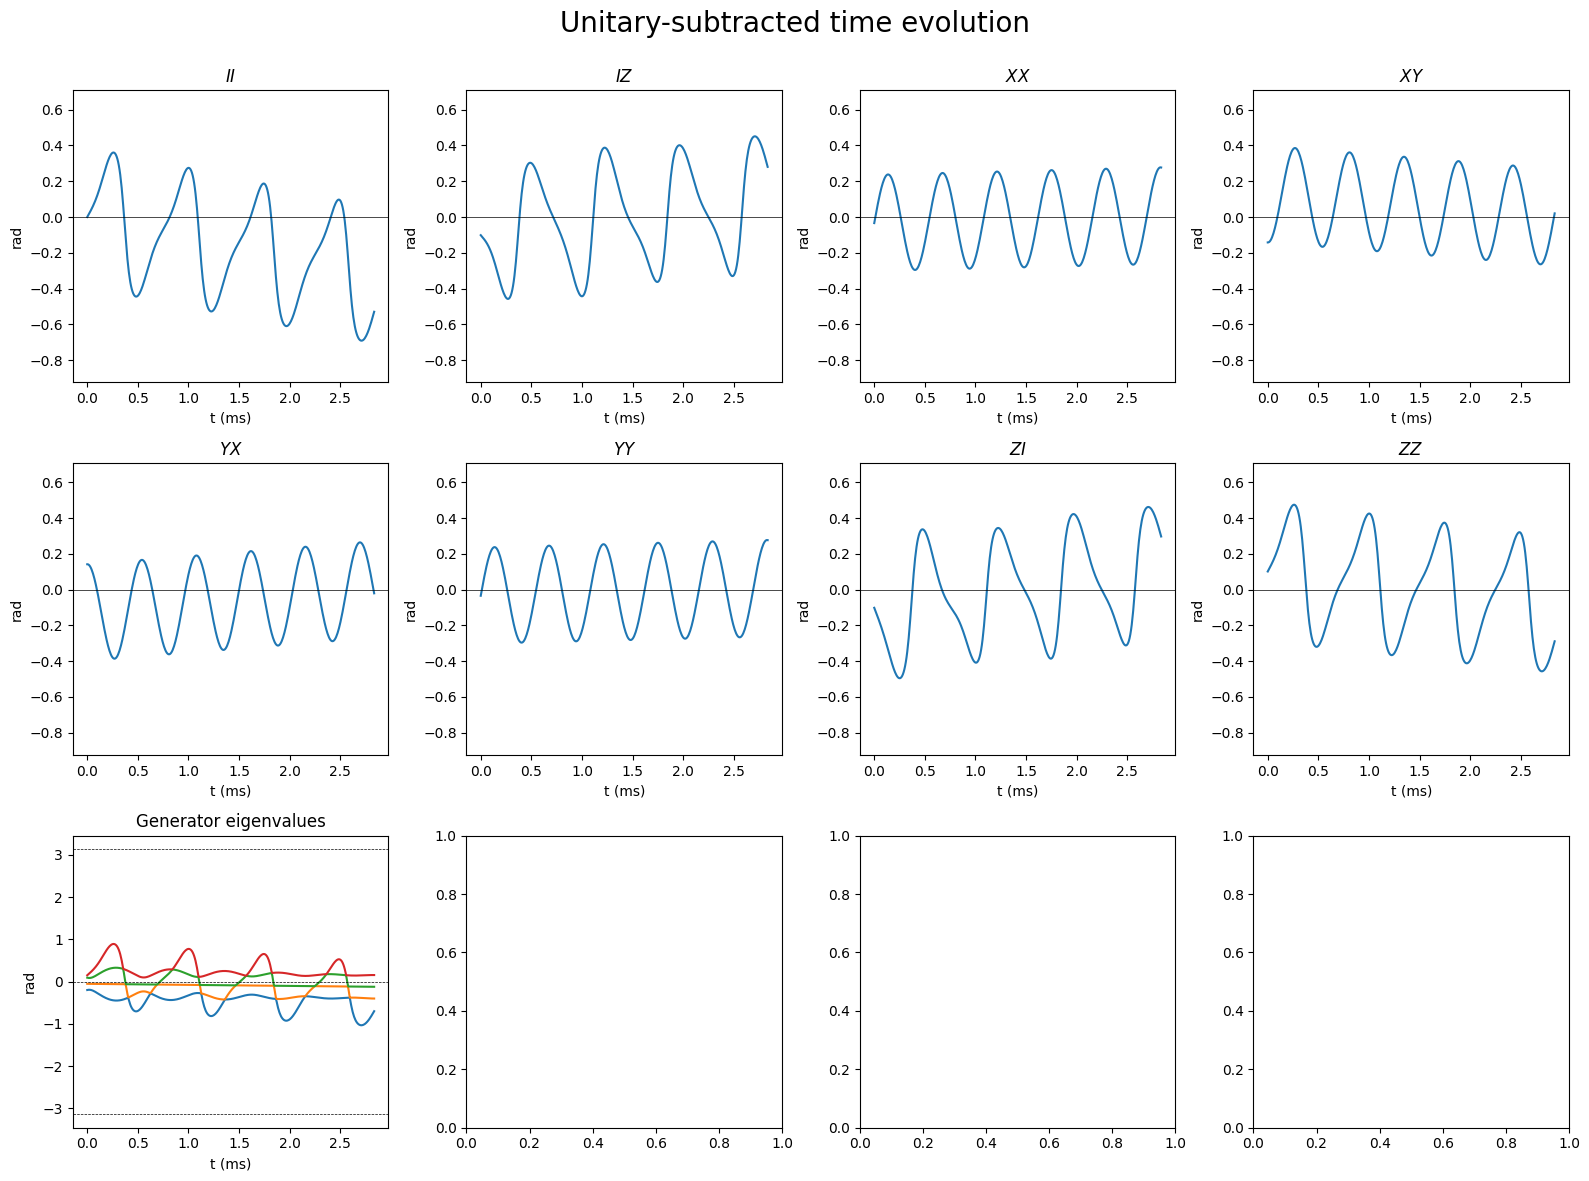

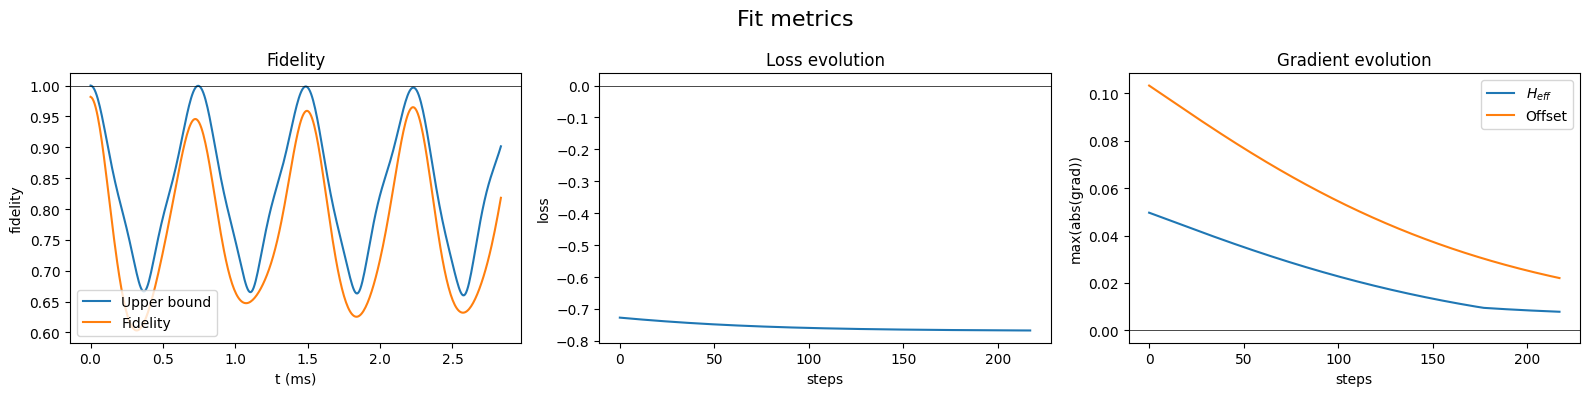

In [28]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/two_qutrit_hstat.h5');

In the qudit frame:

In [29]:
components = qudit_sim.apps.find_heff(hgen,
                                      qudit=tuple(),
                                      frequency=tuple(),
                                      amplitude=tuple(),
                                      comp_dim=2,
                                      frame='qudit',
                                      cycles=50,
                                      min_fidelity=0.5,
                                      save_result_to='heff_validation/two_qutrit_hstat_quditframe')

In [30]:
qudit_sim.visualization.print_components(components)

<IPython.core.display.Latex object>

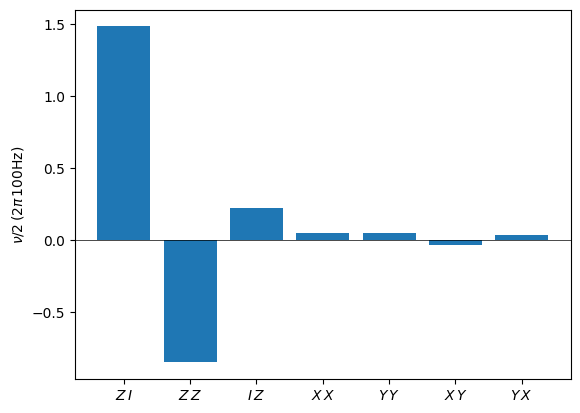

In [31]:
qudit_sim.visualization.plot_components(components);

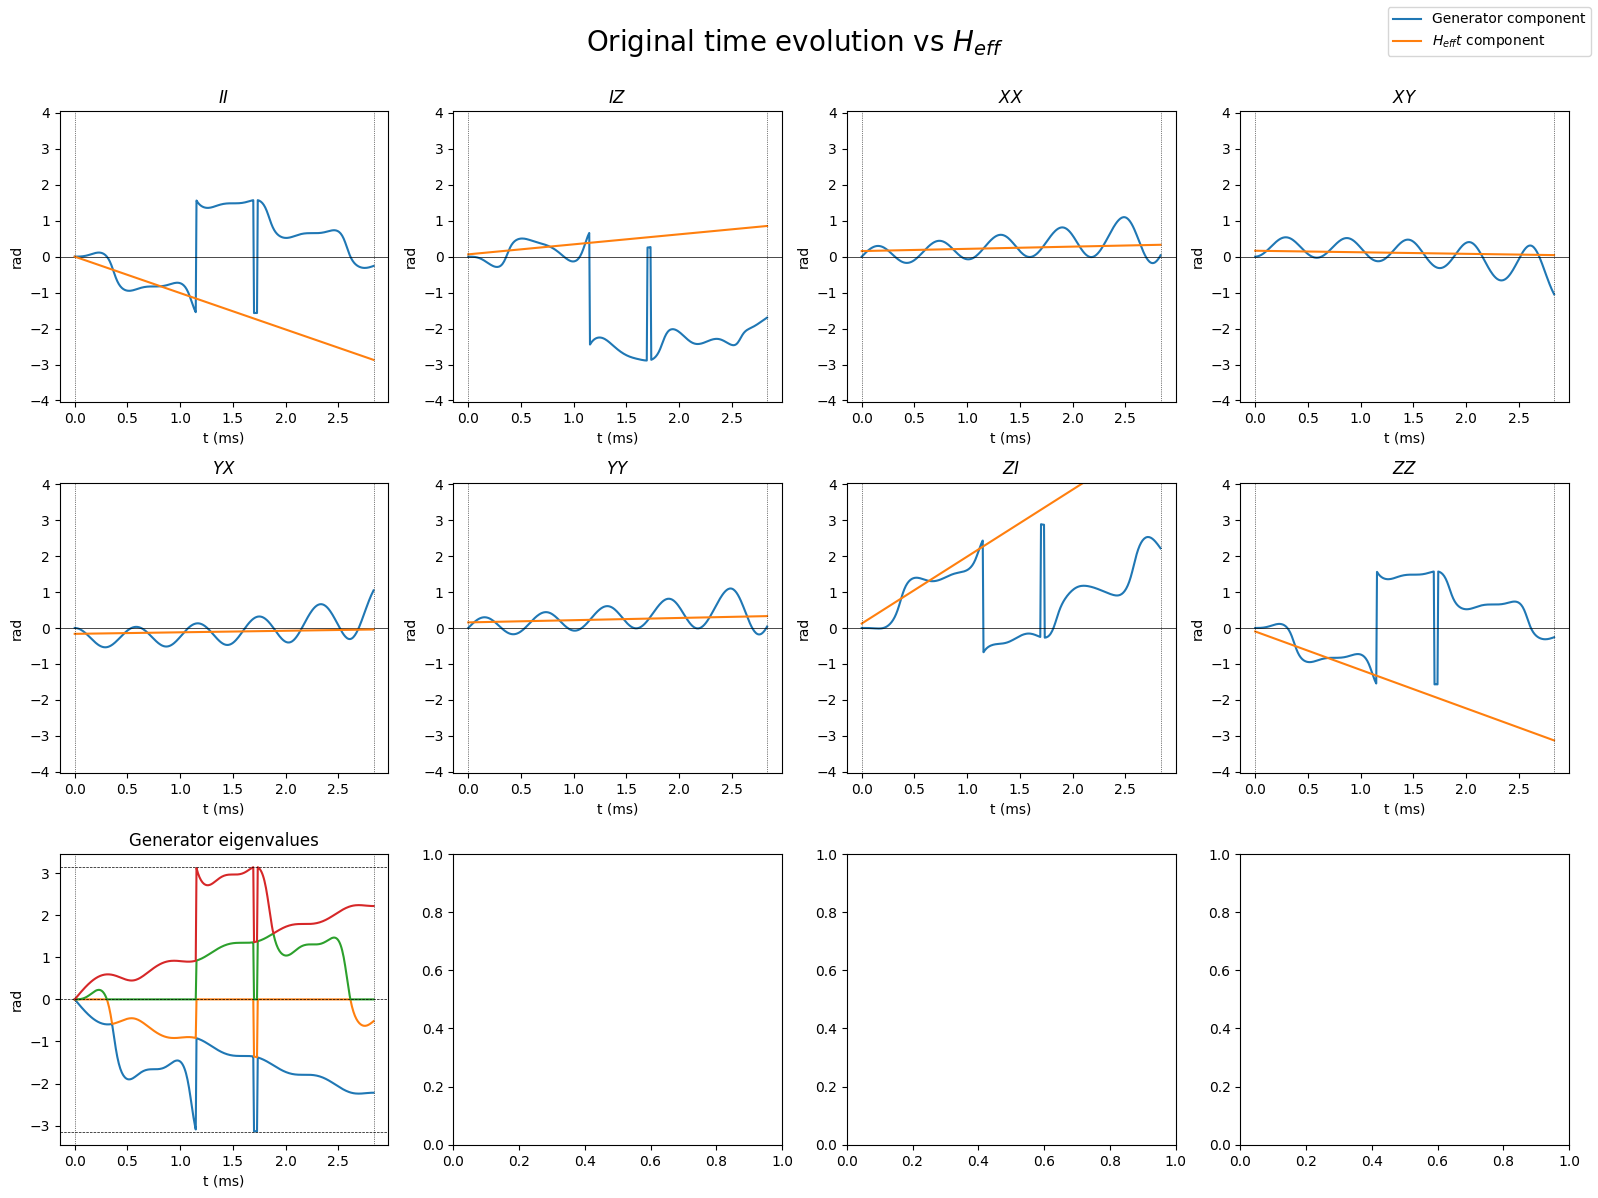

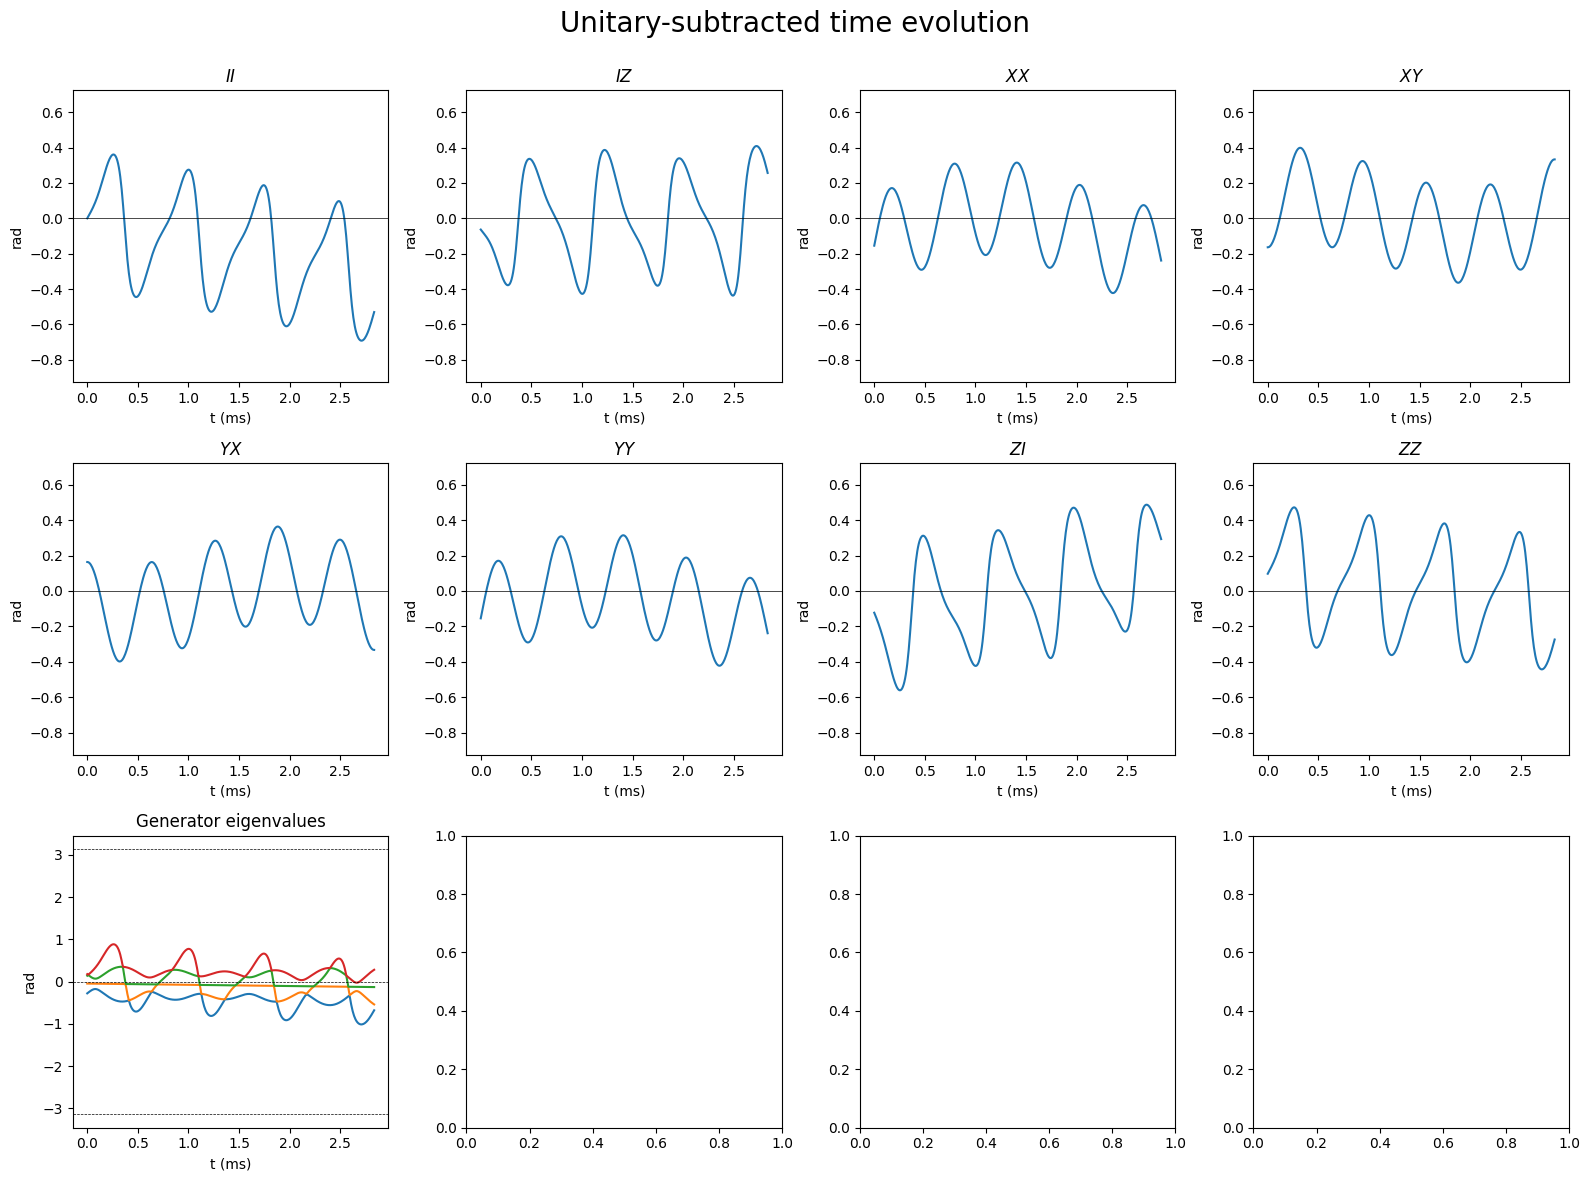

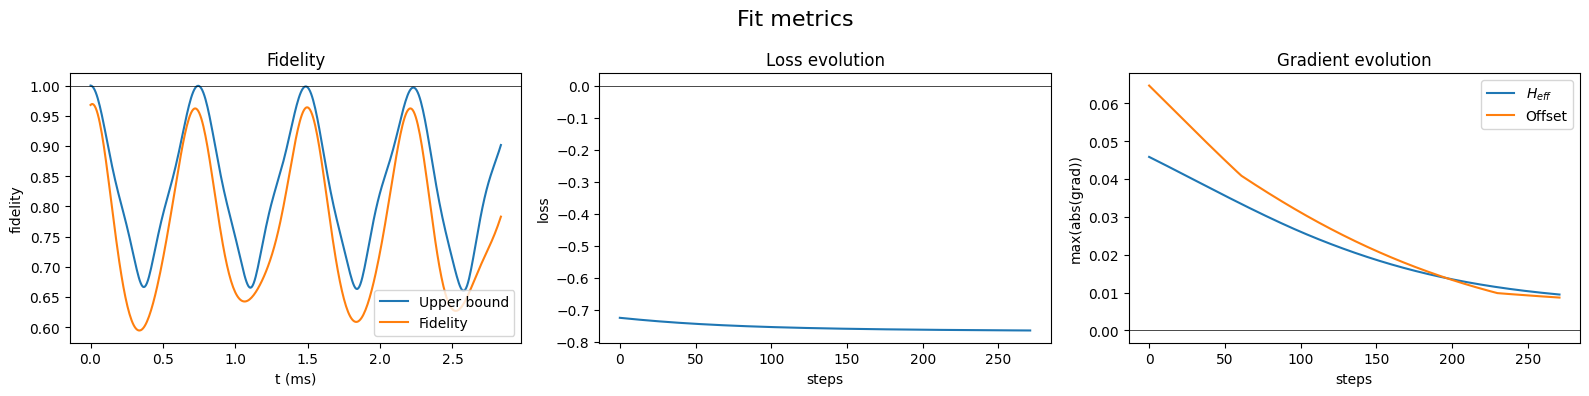

In [32]:
qudit_sim.visualization.inspect_heff_fit('heff_validation/two_qutrit_hstat_quditframe.h5');